# Predictive Maintenance
Data set: https://archive.ics.uci.edu/dataset/316/condition+based+maintenance+of+naval+propulsion+plants

In [164]:
import pandas as pd

In [165]:
columns = ['lp','v','GTT','GTn','GGn','Ts','Tp','T48','T1','T2','P48','P1','P2','Pexh','TIC','mf','kMc','kMt']
data = pd.read_csv('data/data.csv', names=columns, skiprows=1)

# kMc = GT Compressor decay state coefficient, kMt = GT Turbine decay state coefficient
data.head()

lp   v        GTT       GTn       GGn       Ts       Tp      T48   T1  \
0  1.138   3    289.964  1349.489  6677.380    7.584    7.584  464.006  288   
1  2.088   6   6960.180  1376.166  6828.469   28.204   28.204  635.401  288   
2  3.144   9   8379.229  1386.757  7111.811   60.358   60.358  606.002  288   
3  4.161  12  14724.395  1547.465  7792.630  113.774  113.774  661.471  288   
4  5.140  15  21636.432  1924.313  8494.777  175.306  175.306  731.494  288   

        T2    P48     P1      P2   Pexh     TIC     mf   kMc    kMt  
0  550.563  1.096  0.998   5.947  1.019   7.137  0.082  0.95  0.975  
1  581.658  1.331  0.998   7.282  1.019  10.655  0.287  0.95  0.975  
2  587.587  1.389  0.998   7.574  1.020  13.086  0.259  0.95  0.975  
3  613.851  1.658  0.998   9.007  1.022  18.109  0.358  0.95  0.975  
4  645.642  2.078  0.998  11.197  1.026  26.373  0.522  0.95  0.975

In [166]:
data.shape

(11934, 18)

In [167]:
data.describe().round(3)

lp          v        GTT        GTn        GGn         Ts  \
count  11934.000  11934.000  11934.000  11934.000  11934.000  11934.000   
mean       5.167     15.000  27247.499   2136.289   8200.947    227.336   
std        2.626      7.746  22148.613    774.084   1091.316    200.496   
min        1.138      3.000    253.547   1307.675   6589.002      5.304   
25%        3.144      9.000   8375.884   1386.758   7058.324     60.317   
50%        5.140     15.000  21630.659   1924.326   8482.082    175.268   
75%        7.148     21.000  39001.427   2678.079   9132.606    332.365   
max        9.300     27.000  72784.872   3560.741   9797.103    645.249   

              Tp        T48       T1         T2        P48         P1  \
count  11934.000  11934.000  11934.0  11934.000  11934.000  11934.000   
mean     227.336    735.495    288.0    646.215      2.353      0.998   
std      200.496    173.681      0.0     72.676      1.085      0.000   
min        5.304    442.364    288.0    540.442      1.093      0.998   
25%       60.317    589.873    288.0    578.092      1.389      0.998   
50%      175.268    706.038    288.0    637.142      2.083      0.998   
75%      332.365    834.066    288.0    693.924      2.981      0.998   
max      645.249   1115.797    288.0    789.094      4.560      0.998   

              P2       Pexh        TIC         mf        kMc        kMt  
count  11934.000  11934.000  11934.000  11934.000  11934.000  11934.000  
mean      12.297      1.029     33.641      0.662      0.975      0.988  
std        5.337      0.010     25.841      0.507      0.015      0.008  
min        5.828      1.019      0.000      0.068      0.950      0.975  
25%        7.447      1.020     13.678      0.246      0.962      0.981  
50%       11.092      1.026     25.276      0.496      0.975      0.988  
75%       15.658      1.036     44.552      0.882      0.988      0.994  
max       23.140      1.052     92.556      1.832      1.000      1.000

In [168]:
data.kMc

0        0.95
1        0.95
2        0.95
3        0.95
4        0.95
         ... 
11929    1.00
11930    1.00
11931    1.00
11932    1.00
11933    1.00
Name: kMc, Length: 11934, dtype: float64

In [169]:
import pandas as pd

# Define a custom function to determine decay status
def get_decay_status(coeff):
    if coeff < 0.975:
        return 'done'
    elif 0.975 <= coeff < 0.99:
        return 'decaying'
    elif 0.99 <= coeff <= 1:
        return 'not decaying'
    else:
        return 'unknown'  # Handle any other cases here

# Apply the custom function to create the "decay_status" column
data['decay_status_kMc'] = data['kMc'].apply(get_decay_status)

# Print the updated DataFrame
data['decay_status_kMc'].value_counts()

decay_status_kMc
done            5850
decaying        3510
not decaying    2574
Name: count, dtype: int64

In [170]:
# Apply the custom function to create the "decay_status" column
data['decay_status_kMt'] = data['kMt'].apply(get_decay_status)

# Print the updated DataFrame
data['decay_status_kMt'].value_counts()

decay_status_kMt
decaying        6885
not decaying    5049
Name: count, dtype: int64

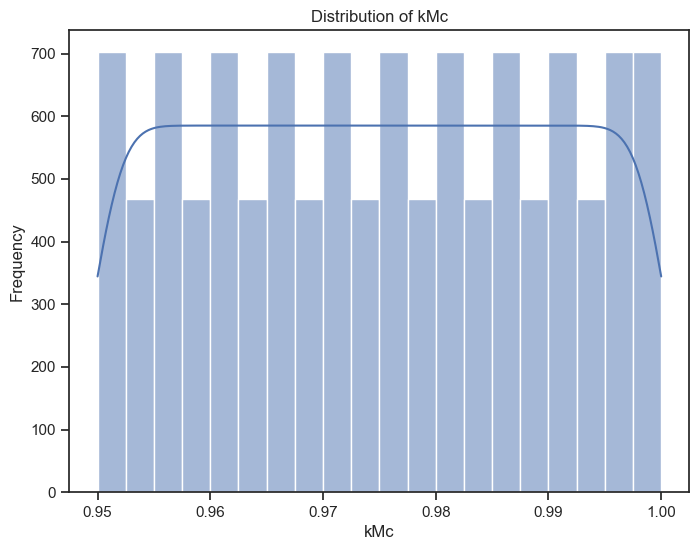

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution plot of 'kMc'
plt.figure(figsize=(8, 6))
sns.histplot(data['kMc'], bins=20, kde=True)
plt.title('Distribution of kMc')
plt.xlabel('kMc')
plt.ylabel('Frequency')
plt.show()

# Create a pairplot grid
sns.set(style="ticks")
#sns.pairplot(data, diag_kind='kde')
#plt.suptitle('Pairplot of All Variables', y=1.02)
#plt.show()

### Training a simple MLP as a baseline to estimate compressor decay

- Defining features and target
- splitting data into train, validation and test data, while shuffling the dataset and keeping distribution

In [172]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

torch.manual_seed(0)

# Split features and target
#features = data.drop(columns=['kMc'])
#target = data['kMc']

features = data.drop(columns=['kMt'])
target = data['kMt']

# Split data into train, validation, and test sets
train_size = 0.7
val_size = 0.15
test_size = 0.15

X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=1 - train_size, random_state=42, stratify=target, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + val_size), random_state=42, stratify=y_temp)

- Checking for equal distribution between all three datasets

In [173]:
X_val.decay_status_kMc.value_counts()

decay_status_kMc
done            863
decaying        545
not decaying    382
Name: count, dtype: int64

In [174]:
X_train.decay_status_kMc.value_counts()

decay_status_kMc
done            4109
decaying        2445
not decaying    1799
Name: count, dtype: int64

In [175]:
X_test.decay_status_kMc.value_counts()

decay_status_kMc
done            878
decaying        520
not decaying    393
Name: count, dtype: int64

In [176]:
X_train = X_train.drop(columns=['decay_status_kMc', 'decay_status_kMt'])
X_val = X_val.drop(columns=['decay_status_kMc', 'decay_status_kMt'])
X_test = X_test.drop(columns=['decay_status_kMc', 'decay_status_kMt'])

In [177]:
# scale the input data for the neural network to improve convergence and speed up training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Defining different MLPs
- starting with a simple MLP to train a regression model

In [178]:
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

In [179]:
class MLP(nn.Module):
    """Configurable class for MLP models"""
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

In [180]:
def train_(model, epochs, X_train_scaled, y_train, X_val_tensor, y_val_tensor, lr=0.001, patience=10):
    """Train without minibatching"""
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_loss = float('inf')
    counter = 0
    
    inputs = torch.tensor(X_train_scaled, dtype=torch.float32)
    targets = torch.tensor(y_train.values, dtype=torch.float32)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        train_loss = criterion(outputs, targets)
        train_loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor).squeeze()
            val_loss = criterion(y_val_pred, y_val_tensor)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
            
        # keep count of training loss for early stopping
        if train_loss < best_loss:
            best_loss = train_loss
            counter = 0
        else:
            counter += 1
            
        # check if early stopping criteria has been met
        if counter >= patience:
            print("Early stopping")
            break

In [181]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

def train(model, epochs, X_train_scaled, y_train, X_val_tensor, y_val_tensor, lr=0.001, batch_size=64, patience=10):
    """Traing with minibatching"""
    # Create DataLoader for training and validation
    train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                                  torch.tensor(y_train.values, dtype=torch.float32))
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    inputs = torch.tensor(X_train_scaled, dtype=torch.float32)
    targets = torch.tensor(y_train.values, dtype=torch.float32)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_loss = float('inf')
    counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            batch_loss = criterion(outputs, targets)
            batch_loss.backward()
            optimizer.step()
        
        # Calculate train and validation loss for epoch
        model.eval()
        with torch.no_grad():
            y_train_pred = model(inputs).squeeze()
            train_loss = criterion(y_train_pred, targets)
            y_val_pred = model(X_val_tensor).squeeze()
            val_loss = criterion(y_val_pred, y_val_tensor)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            
        # keep count of training loss for early stopping
        if train_loss < best_loss:
            best_loss = train_loss
            counter = 0
        else:
            counter += 1
            
        # check if early stopping criteria has been met
        if counter >= patience:
            print(f"Early stopping after {epoch}.")
            break

In [182]:
hidden_sizes = [64]
input_dim = X_train_scaled.shape[1]
output_size = 1 

mlp1 = MLP(input_dim, hidden_sizes, output_size, dropout_prob=0.0)

In [183]:
train(mlp1, 100, X_train_scaled, y_train, X_val_tensor, y_val_tensor)

Early stopping after 74.


In [184]:
def evaluate(model, X_test_scaled, y_test):

    model.eval()
    with torch.no_grad():
        test_inputs = torch.tensor(X_test_scaled, dtype=torch.float32)
        test_targets = torch.tensor(y_test.values, dtype=torch.float32)
        test_outputs = model(test_inputs).squeeze()

    mae = nn.L1Loss()
    mae = mae(test_outputs, test_targets)
    mse_o = nn.MSELoss()
    mse = mse_o(test_outputs, test_targets)
    rmse = torch.sqrt(mse_o(test_outputs, test_targets))
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

In [185]:
evaluate(mlp1, X_test_scaled, y_test)

Mean Absolute Error (MAE): 0.0035
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0042


In [186]:
test_inputs = torch.tensor(X_test_scaled, dtype=torch.float32)
test_outputs = mlp1(test_inputs)
eval_df = pd.DataFrame({'target': y_test.tolist(), 'prediction': [value.item() for value in test_outputs]})
eval_df['decay_status_target'] = eval_df['target'].apply(get_decay_status)
eval_df['decay_status_pred'] = eval_df['prediction'].apply(get_decay_status)

eval_df.head()

target  prediction decay_status_target decay_status_pred
0   0.977    0.977556            decaying          decaying
1   0.985    0.985619            decaying          decaying
2   0.988    0.990825            decaying      not decaying
3   0.983    0.984561            decaying          decaying
4   0.976    0.987400            decaying          decaying

In [187]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

y_true = eval_df['decay_status_target']
y_pred = eval_df['decay_status_pred']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.7052
Recall: 0.7052
Precision: 0.8398
F1-score: 0.7656


C:\Users\Luca\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### More complex MLP

In [188]:
input_dim = X_train_scaled.shape[1]
hidden_sizes = [24, 12, 6]  # definition of hidden layers
output_size = 1 

# Create the model
mlp2 = MLP(input_dim, hidden_sizes, output_size, dropout_prob=0.0)
print(mlp2)

MLP(
  (network): Sequential(
    (0): Linear(in_features=17, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=12, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.0, inplace=False)
    (5): Linear(in_features=12, out_features=6, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.0, inplace=False)
    (8): Linear(in_features=6, out_features=1, bias=True)
  )
)


In [189]:
train(mlp2, 5000, X_train_scaled, y_train, X_val_tensor, y_val_tensor)

Early stopping after 84.


In [190]:
evaluate(mlp2, X_test_scaled, y_test)

Mean Absolute Error (MAE): 0.0012
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0017


### Even more complex MLP

### regarding compressor decay state kMc
- just increasing the size of the hidden layers does not work
    - adding an additional layer helps to converge faster, but without better results
        - the bigger the network, the faster the convergence (early stopping is applied), but without better results on the test set
    - the RMSE is the same on the training, validation and test set, so overfitting isn't a problem (yet), is it?
        - so early stopping based on the training loss shouln't be an issue right now, right?
    - increasing the learning rate to 0.01 leads to instant early stopping and underfitting
    - increasing the learning rate to 0.005 leads to way faster convergence with early stopping after ca. 400 epochs, but with similar performance on all datasets
    - minibatches with a batch size of 64 and a learning rate of 0.001 leads to a very fast convergence to 0.0002 train and validation loss -> results similar across all tried model configurations, training takes more time per epoch (as expected)
    - there does not seem to be overfitting, because the loss on the test dataset is identical to the train and validation loss
        - increasing the network size (size of the hidden layers and additional hidden layers) does not lead to better results
        - dropout does not lead to better results
        - the explored model architectures don't seem to be able to capture the problem as well as a simple XGBRegressor does

    ToDo:
    - further increase network size

    Question:
    - are there other neural network types suitable for this problem?
        - LSTM, attention and CNN are not suitable imo
            - LSTM = sequence data, no natural order in the observations of turbine and compressor decay state
            - attention = 
            - CNN = for image data, to capture spatial relationships within the image (pixels)
    - what to do?

In [191]:
# Define input size, hidden layer sizes, and output size
hidden_sizes = [192, 288, 192, 96, 24]  # definition of hidden layers
output_size = 1 

# Create the model
mlp3 = MLP(input_dim, hidden_sizes, output_size, dropout_prob=0.5)
print(mlp3)

MLP(
  (network): Sequential(
    (0): Linear(in_features=17, out_features=192, bias=True)
    (1): ReLU()
    (2): Linear(in_features=192, out_features=288, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=288, out_features=192, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=192, out_features=96, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=96, out_features=24, bias=True)
    (12): ReLU()
    (13): Dropout(p=0.5, inplace=False)
    (14): Linear(in_features=24, out_features=1, bias=True)
  )
)


In [192]:
train(mlp3, 1000, X_train_scaled, y_train, X_val_tensor, y_val_tensor)

Early stopping after 40.


In [193]:
evaluate(mlp3, X_test_scaled, y_test)

Mean Absolute Error (MAE): 0.0065
Mean Squared Error (MSE): 0.0001
Root Mean Squared Error (RMSE): 0.0075


### XGBoostRegressor

In [194]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create an XGBRegressor model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,  # Number of boosting rounds
    learning_rate=0.1,  # Learning rate
    max_depth=3,  # Maximum depth of each tree
    objective='reg:squarederror',  # Regression task
    random_state=42
)

# Train the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict the target variable on the test data
y_pred = xgb_model.predict(X_test_scaled)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred, squared=True)

print("Mean Absolute Error:", "{:.10f}".format(mae))
print("Mean Squared Error:", "{:.10f}".format(mse))
print("Root Mean Squared Error:", "{:.10f}".format(rmse))

Mean Absolute Error: 0.0024443827
Mean Squared Error: 0.0000105416
Root Mean Squared Error: 0.0032467868
